# MAD Portfolio Optimization

This notebook demonstrates portfolio optimization using the Mean Absolute Deviation (MAD) criterion. A portion of these notes is adapted from [GLPK Wikibook tutorial on the subject](http://en.wikibooks.org/wiki/GLPK/Portfolio_Optimization) written by me.

J.C. Kantor (Kantor.1@nd.edu)

## Investment Objectives

* Maximize returns
* Reduce Risk through diversification

## Why Diversify?

Investment portfolios are collections of investments that are managed for overall investment return.  Compared to investing all of your capital into a single asset, maintaining a portfolio of investments allows you to manage risk through diversification.

### Reduce Risk through Law of Large Numbers

Suppose there are a set of independent investment opportunities that will pay back between 0 and 300% of your original investment, and that all outcomes in that range are equally likely. You have $100,000 to invest.  Should you put it all in one opportunity?  Or should you spread it around?

Here we simulate the outcomes of 1000 trials where we place all the money into a sigle investment of $100,000.

Average Profit = $48178


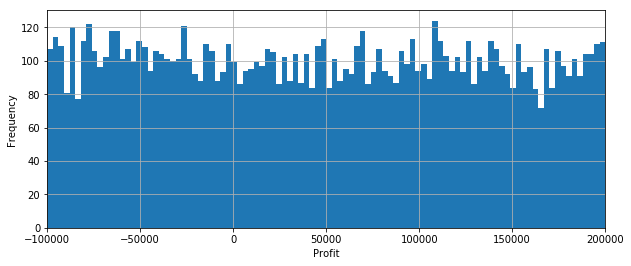

In [74]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import numpy as np

W0 = 100000.00

Ntrials = 10000
Profit = list()
for n in range(0, Ntrials):
    W1 = W0*random.uniform(0,3.00)
    Profit.append(W1 - W0)

plt.figure(figsize=(10,4))
plt.hist(Profit, bins=100)
plt.xlim(-100000, 200000)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.grid()

print('Average Profit = ${:.0f}'.format(np.mean(Profit)))

As you would expect, about 1/3 of the time there is a loss, and about 2/3 of the time there is a profit. In the extreme we can lose all of our invested capital. Is this an acceptable investment outcome?

Now let's see if what happens if we diversify our investment. We'll assume the investment outcomes have exactly the same probabilities. The only difference is that instead of one big investment of \$100,000, we'll break our capital into 5 smaller sized investments of \$20,000 each. We'll calculate the probability distribution of outcomes.

Average Profit = $49151


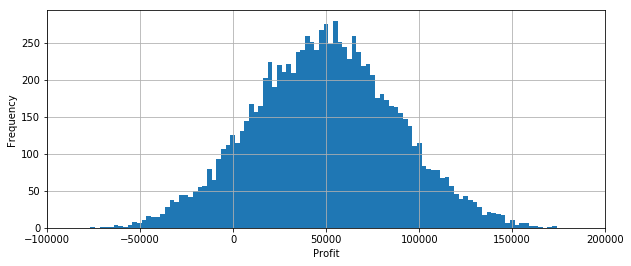

In [75]:
W0 = 100000.00

Ntrials = 10000
Ninvestments = 5

Profit = list()
for n in range(0,Ntrials):
    W1 = sum([(W0/Ninvestments)*random.uniform(0,3.00) for _ in range(0,Ninvestments)])
    Profit.append(W1-W0)

plt.figure(figsize=(10,4))
plt.hist(Profit, bins=100)
plt.xlim(-100000, 200000)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.grid()

print('Average Profit = ${:.0f}'.format(np.mean(Profit)))

What we observe is that even a small amount of diversification can dramatically reduce the downside risk of experiencing a loss. We also see the upside potential has been reduced. What hasn't changed is the that average profit remains at \$50,000. Whether or not the loss of upside potential in order to reduce downside risk is an acceptable tradeoff depends on your individual attitude towards risk. 

### Value at Risk (VaR)

[Value at risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk) is a measure of investment risk. Given a histogram of possible outcomes for the profit of a portfolio, VaR corresponds to negative value of the 5th percentile. That is, 5% of all outcomes would have a lower outcome, and 95% would have a larger outcome. 

The [conditional value at risk](https://en.wikipedia.org/wiki/Expected_shortfall) (also called the expected shortfall (ES), average value at risk (aVaR), and the expected tail loss (ETL)) is the negative of the average value of the lowest 5% of outcomes. 

The following cell provides an interactive demonstration. Use the slider to determine how to break up the total available capital into a number of smaller investments in order to reduce the value at risk to an acceptable (to you) level.  If you can accept only a 5% probability of a loss in your portfolio, how many individual investments would be needed?

In [76]:
from statsmodels.distributions import ECDF
from ipywidgets import interact

W0 = 100000.00

Ntrials = 10000

def sim(Ninvestments = 5):

    Profit = list()
    for n in range(0,Ntrials):
        W1 = sum([(W0/Ninvestments)*random.uniform(0,3.00) for _ in range(0,Ninvestments)])
        Profit.append(W1-W0)
        
    print('Average Profit = ${:.0f}'.format(np.mean(Profit)).replace('$-','-$'))

    VaR = -sorted(Profit)[int(0.05*Ntrials)]
    print('Value at Risk (95%) = ${:.0f}'.format(VaR).replace('$-','-$'))
    
    cVaR = -sum(sorted(Profit)[0:int(0.05*Ntrials)])/(0.05*Ntrials)
    print('Conditional Value at Risk (95%) = ${:.0f}'.format(cVaR).replace('$-','-$'))

    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.hist(Profit, bins=100)
    plt.xlim(-100000, 200000)
    plt.plot([-VaR, -VaR],plt.ylim())
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    plt.grid()

    plt.subplot(2,1,2)
    ecdf = ECDF(Profit)
    x = np.linspace(min(Profit),max(Profit))
    plt.plot(x,ecdf(x))
    plt.xlim(-100000, 200000)
    plt.ylim(0,1)
    plt.plot([-VaR, -VaR],plt.ylim())
    plt.plot(plt.xlim(), [0.05, 0.05])
    plt.xlabel('Profit')
    plt.ylabel('Cumulative Probability')
    plt.grid();
    
interact(sim, Ninvestments = (1,20))

A Jupyter Widget

<function __main__.sim>

## Import Historical Stock Price Data

In [77]:
import pandas as pd

S_hist = pd.read_csv('Historical_Adjusted_Close.csv', index_col=0)
S_hist.dropna(axis=1, how='any', inplace=True)
print(S_hist.columns)

portfolio = list(S_hist.columns)

Index(['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'F', 'GE', 'GS', 'HD',
       'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
       'PFE', 'PG', 'T', 'TRV', 'UNH', 'UTX', 'VZ', 'WMT', 'XOM'],
      dtype='object')


## Select a Subperiod of the Historical Data

In [78]:
nYears = 3
start = S_hist.index[-nYears*252]
end = S_hist.index[-1]

print('Start Date:', start)
print('  End Date:', end)

S = S_hist.loc[start:end]
S.head()

Start Date: 2015-05-11
  End Date: 2018-05-09


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,F,GE,GS,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2015-05-11,120.0567,75.8379,134.8529,80.3171,26.4093,94.5693,104.0961,13.0703,24.4377,193.6878,...,49.5874,30.6962,72.8117,28.7109,95.4589,109.3653,108.7049,43.2727,72.4590,78.4670
2015-05-12,119.6243,75.2480,134.4277,79.7652,26.4274,94.7455,104.7095,12.9951,24.5376,192.5356,...,49.3848,30.5335,72.5215,28.8566,94.9453,109.2414,108.3909,43.1163,73.2569,78.6841
2015-05-13,119.7621,75.9902,134.6033,80.0185,26.5359,94.8688,104.6616,12.8698,24.7010,193.3997,...,49.2835,30.3075,72.2947,29.0624,95.2254,110.4040,108.9912,43.2119,72.5146,78.2681
2015-05-14,122.5563,76.8371,136.7663,80.2900,26.2646,95.5295,105.3709,12.7529,24.8825,194.5423,...,49.9010,30.6781,73.0839,29.2596,95.9538,112.9482,110.6349,43.4204,73.0342,78.6388
2015-05-15,122.3853,76.3327,135.7680,80.0095,26.7167,96.1020,105.7256,12.9283,24.7554,194.8784,...,50.6439,30.7233,73.5193,29.4310,95.8885,113.7106,110.0313,43.2640,73.5166,78.9824


## Equally Weighted Portfolio

An equally weighted portfolio places an equal amount of capital in each component of the portfolio. Letting $w_{j,t}$ denote the fraction of the portfolio value invested in asset $j$ at time $t$, 

T

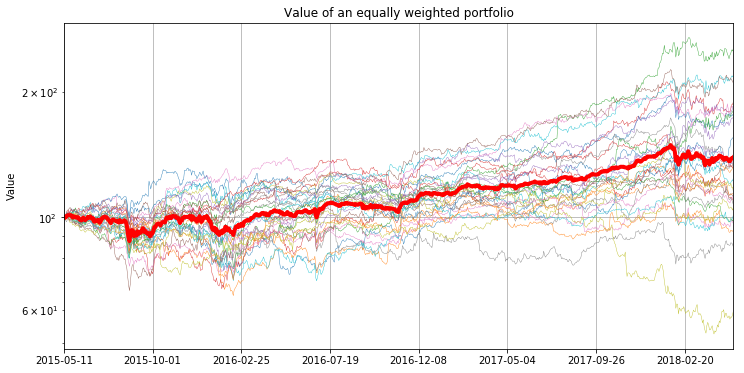

In [79]:
plt.figure(figsize=(12,6))
for s in portfolio:
    (100.0*S[s]/S[s][0]).plot(lw=0.4, logy=True)
    
P_equal = pd.Series(0, index=S.index)
for s in portfolio:
    P_equal += 100.0*S[s]/S[s][0]/len(portfolio)

P_equal.plot(color='r',lw=4, logy=True)
plt.ylabel('Value');
plt.title('Value of an equally weighted portfolio')
plt.grid()

### Compute Component Returns

Arithmetic returns are required because subsequent calculations will be combining returns across components of a portfolio.

Text(0.5,1,'Standard Deviation')

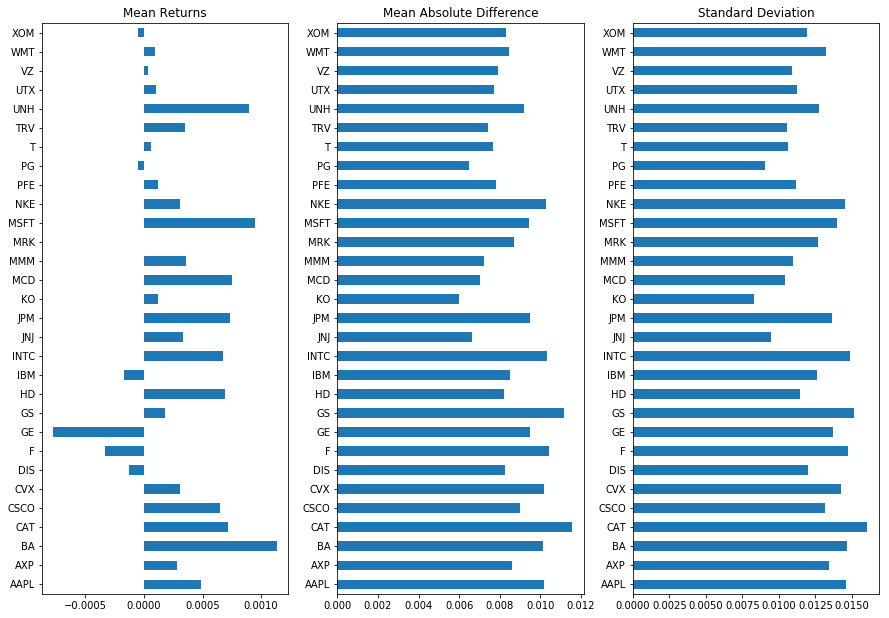

In [56]:
R = (S.diff()[1:]/S[1:]).dropna(axis=0, how='all')
#R = np.log(S/S.shift(+1)).dropna(axis=0, how='all')
AD = abs(R-R.mean())

plt.figure(figsize = (15,0.35*len(R.columns)))
plt.subplot(1,3,1)
R.mean().plot(kind='barh')
plt.title('Mean Returns');

plt.subplot(1,3,2)
AD.mean().plot(kind='barh')
plt.title('Mean Absolute Difference')

plt.subplot(1,3,3)
R.std().plot(kind='barh')
plt.title('Standard Deviation')

In [58]:
R.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,F,GE,GS,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2015-05-12,-0.003615,-0.007839,-0.003163,-0.006919,0.000685,0.001860,0.005858,-0.005787,0.004071,-0.005984,...,-0.004102,-0.005329,-0.004002,0.005049,-0.005409,-0.001134,-0.002897,-0.003627,0.010892,0.002759
2015-05-13,0.001151,0.009767,0.001305,0.003166,0.004089,0.001300,-0.000458,-0.009736,0.006615,0.004468,...,-0.002055,-0.007457,-0.003137,0.007081,0.002941,0.010530,0.005508,0.002212,-0.010237,-0.005315
2015-05-14,0.022799,0.011022,0.015815,0.003381,-0.010329,0.006916,0.006731,-0.009167,0.007294,0.005873,...,0.012375,0.012080,0.010799,0.006740,0.007591,0.022525,0.014857,0.004802,0.007114,0.004714
2015-05-15,-0.001397,-0.006608,-0.007353,-0.003506,0.016922,0.005957,0.003355,0.013567,-0.005134,0.001725,...,0.014669,0.001471,0.005922,0.005824,-0.000681,0.006705,-0.005486,-0.003615,0.006562,0.004350
2015-05-18,0.010907,-0.000623,-0.001159,-0.001586,0.007058,-0.012939,0.000271,0.006417,0.001464,0.008257,...,-0.002197,-0.000293,-0.003840,0.015488,0.004750,0.003923,0.000169,-0.003831,0.008509,-0.005757


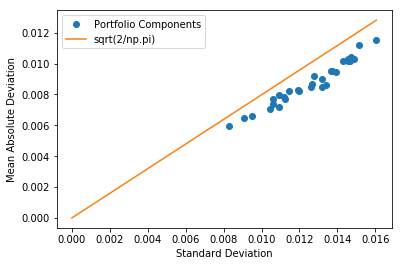

In [59]:
plt.plot(R.std(), AD.mean(), 'o')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Absolute Deviation')

plt.plot([0,R.std().max()],[0,np.sqrt(2.0/np.pi)*R.std().max()])
plt.legend(['Portfolio Components','sqrt(2/np.pi)'],loc='best');

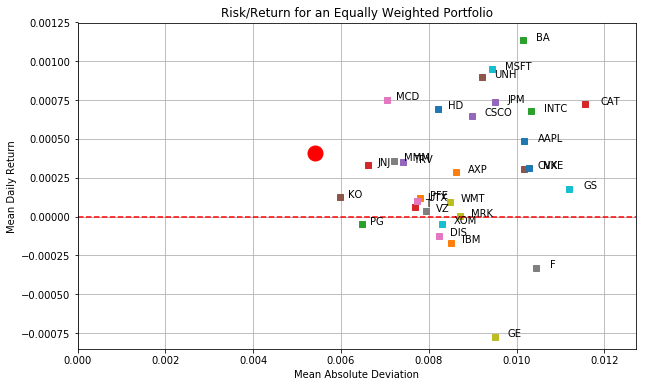

In [67]:
plt.figure(figsize=(10,6))
for s in portfolio:
    plt.plot(AD[s].mean(), R[s].mean(),'s')
    plt.text(AD[s].mean()*1.03, R[s].mean(), s)
    
R_equal = P_equal.diff()[1:]/P_equal[1:]
#R_equal = np.log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plt.plot(M_equal, R_equal.mean(), 'ro', ms=15)

plt.xlim(0, 1.1*max(AD.mean()))
plt.ylim(min(0, 1.1*min(R.mean())), 1.1*max(R.mean()))
plt.plot(plt.xlim(),[0,0],'r--');
plt.title('Risk/Return for an Equally Weighted Portfolio')
plt.xlabel('Mean Absolute Deviation')
plt.ylabel('Mean Daily Return')

plt.grid();

## MAD Porfolio

The linear program is formulated and solved using the pulp package. 

In [68]:
R.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,F,GE,GS,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2015-05-12,-0.003615,-0.007839,-0.003163,-0.006919,0.000685,0.001860,0.005858,-0.005787,0.004071,-0.005984,...,-0.004102,-0.005329,-0.004002,0.005049,-0.005409,-0.001134,-0.002897,-0.003627,0.010892,0.002759
2015-05-13,0.001151,0.009767,0.001305,0.003166,0.004089,0.001300,-0.000458,-0.009736,0.006615,0.004468,...,-0.002055,-0.007457,-0.003137,0.007081,0.002941,0.010530,0.005508,0.002212,-0.010237,-0.005315
2015-05-14,0.022799,0.011022,0.015815,0.003381,-0.010329,0.006916,0.006731,-0.009167,0.007294,0.005873,...,0.012375,0.012080,0.010799,0.006740,0.007591,0.022525,0.014857,0.004802,0.007114,0.004714
2015-05-15,-0.001397,-0.006608,-0.007353,-0.003506,0.016922,0.005957,0.003355,0.013567,-0.005134,0.001725,...,0.014669,0.001471,0.005922,0.005824,-0.000681,0.006705,-0.005486,-0.003615,0.006562,0.004350
2015-05-18,0.010907,-0.000623,-0.001159,-0.001586,0.007058,-0.012939,0.000271,0.006417,0.001464,0.008257,...,-0.002197,-0.000293,-0.003840,0.015488,0.004750,0.003923,0.000169,-0.003831,0.008509,-0.005757


The decision variables will be indexed by date/time.  The pandas dataframes containing the returns data are indexed by timestamps that include characters that cannot be used by the GLPK solver. Therefore we create a dictionary to translate the pandas timestamps to strings that can be read as members of a GLPK set. The strings denote seconds in the current epoch as defined by python.

In [69]:
a = R - R.mean()
a.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,F,GE,GS,...,NKE,PFE,PG,T,TRV,UNH,UTX,VZ,WMT,XOM
2015-05-12,-0.004098,-0.008123,-0.004298,-0.007640,0.000035,0.001553,0.005983,-0.005458,0.004845,-0.006164,...,-0.004414,-0.005446,-0.003952,0.004987,-0.005760,-0.002033,-0.002999,-0.003660,0.010797,0.002805
2015-05-13,0.000667,0.009483,0.000170,0.002444,0.003439,0.000993,-0.000333,-0.009407,0.007389,0.004288,...,-0.002367,-0.007574,-0.003088,0.007019,0.002591,0.009632,0.005405,0.002180,-0.010331,-0.005269
2015-05-14,0.022316,0.010738,0.014681,0.002660,-0.010979,0.006610,0.006856,-0.008838,0.008068,0.005694,...,0.012063,0.011963,0.010848,0.006677,0.007240,0.021627,0.014755,0.004769,0.007020,0.004760
2015-05-15,-0.001881,-0.006892,-0.008488,-0.004227,0.016272,0.005651,0.003479,0.013896,-0.004360,0.001545,...,0.014358,0.001354,0.005971,0.005761,-0.001032,0.005806,-0.005588,-0.003648,0.006467,0.004397
2015-05-18,0.010424,-0.000906,-0.002294,-0.002307,0.006408,-0.013246,0.000396,0.006746,0.002238,0.008078,...,-0.002508,-0.000410,-0.003790,0.015426,0.004399,0.003024,0.000067,-0.003863,0.008414,-0.005711


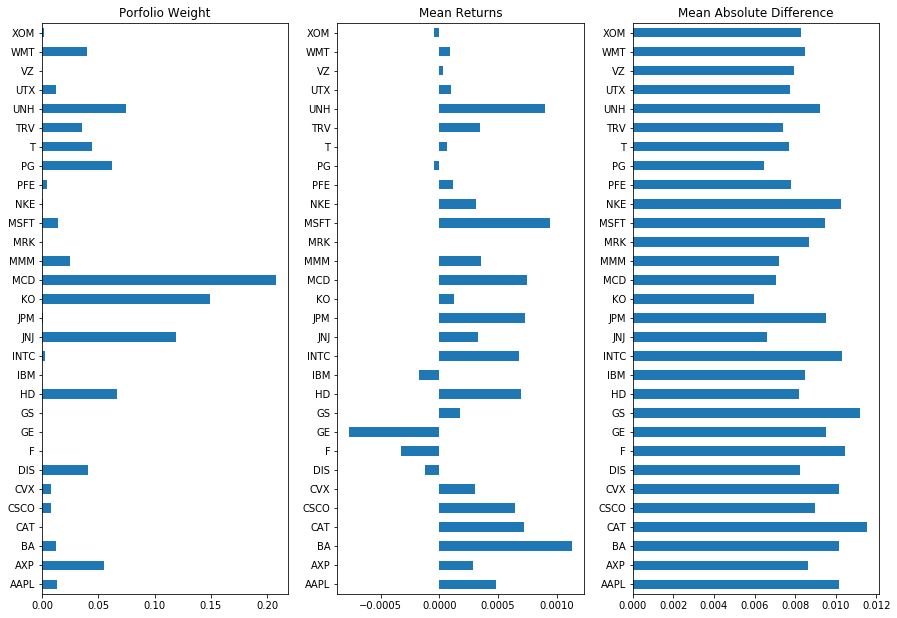

In [70]:
from pyomo.environ import *

a = R - R.mean()

m = ConcreteModel()

m.w = Var(R.columns, domain=NonNegativeReals)
m.y = Var(R.index, domain=NonNegativeReals)

m.MAD = Objective(expr=sum(m.y[t] for t in R.index)/len(R.index), sense=minimize)

m.c1 = Constraint(R.index, rule = lambda m, t:
    m.y[t] + sum(a.loc[t,s]*m.w[s] for s in R.columns) >= 0)

m.c2 = Constraint(R.index, rule = lambda m, t:
    m.y[t] - sum(a.loc[t,s]*m.w[s] for s in R.columns) >= 0)

m.c3 = Constraint(expr=sum(R[s].mean()*m.w[s] for s in R.columns) >= R_equal.mean())

m.c4 = Constraint(expr=sum(m.w[s] for s in R.columns)==1)

SolverFactory('glpk').solve(m)

w = {s: m.w[s]() for s in R.columns}

plt.figure(figsize = (15,0.35*len(R.columns)))

plt.subplot(1,3,1)
pd.Series(w).plot(kind='barh')
plt.title('Porfolio Weight');

plt.subplot(1,3,2)
R.mean().plot(kind='barh')
plt.title('Mean Returns');

plt.subplot(1,3,3)
AD.mean().plot(kind='barh')
plt.title('Mean Absolute Difference');

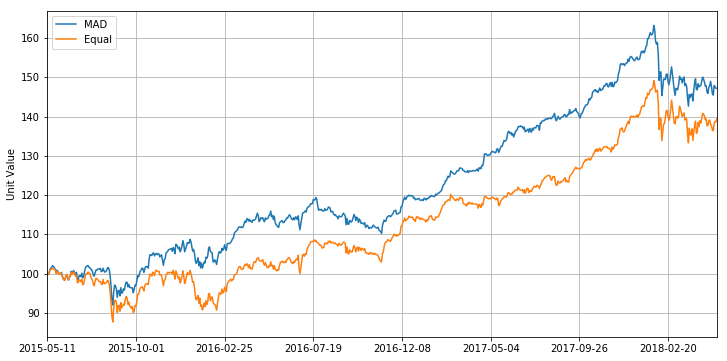

In [71]:
P_mad = pd.Series(0,index=S.index)
for s in portfolio:
    P_mad += 100.0*w[s]*S[s]/S[s][0]
    
plt.figure(figsize=(12,6))
P_mad.plot()
P_equal.plot()
plt.legend(['MAD','Equal'],loc='best')
plt.ylabel('Unit Value')
plt.grid()

In [72]:
w['F']

0.0

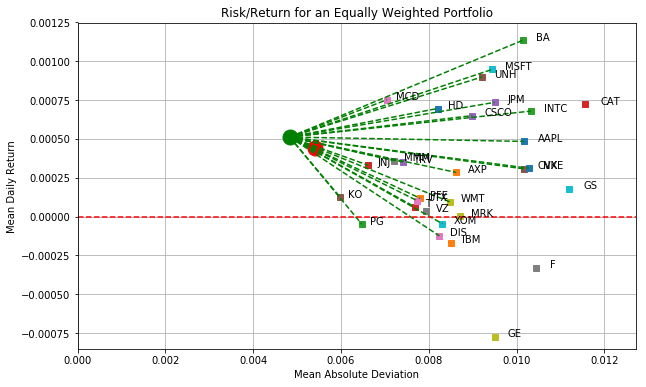

In [73]:
plt.figure(figsize=(10,6))
for s in portfolio:
    plt.plot(AD[s].mean(), R[s].mean(),'s')
    plt.text(AD[s].mean()*1.03, R[s].mean(), s)
    
#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = np.log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plt.plot(M_equal, R_equal.mean(), 'ro', ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = np.log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

plt.plot(M_mad, R_mad.mean(), 'go', ms=15)

for s in portfolio:
    if w[s] >= 0.0001:
        plt.plot([M_mad, AD[s].mean()],[R_mad.mean(), R[s].mean()],'g--')
    if w[s] <= -0.0001:
        plt.plot([M_mad, AD[s].mean()],[R_mad.mean(), R[s].mean()],'r--')

plt.xlim(0, 1.1*max(AD.mean()))
plt.ylim(min(0, 1.1*min(R.mean())), 1.1*max(R.mean()))
plt.plot(plt.xlim(),[0,0],'r--');
plt.title('Risk/Return for an Equally Weighted Portfolio')
plt.xlabel('Mean Absolute Deviation')
plt.ylabel('Mean Daily Return')

plt.grid();

In [164]:


import pulp

# mean absolute deviation for the portfolio
m = pulp.LpVariable('m', lowBound = 0)

# dictionary of portfolio weights
w = pulp.LpVariable.dicts('w', portfolio, lowBound = 0)

# dictionary of absolute deviations of portfolio returns
y = pulp.LpVariable.dicts('y', t.values(), lowBound = 0)
z = pulp.LpVariable.dicts('z', t.values(), lowBound = 0)

# create problem instance
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)

# add objective
lp += m

# calculate mean absolute deviation of portfolio returns
lp += m == pulp.lpSum([(y[k] + z[k]) for k in t.values()])/float(len(t))

# relate the absolute deviations to deviations in the portfolio returns
for ts in returns.index:
    lp += y[t[ts]] - z[t[ts]] == pulp.lpSum([w[s]*(returns[s][ts]-returns[s].mean()) for s in portfolio]) 
    
# portfolio weights
lp += pulp.lpSum([w[s] for s in portfolio]) == 1.0

# bound on average portfolio return
lp += pulp.lpSum([w[s]*(returns[s].mean()) for s in portfolio]) >= 0*R_equal.mean()

lp.solve()
print pulp.LpStatus[lp.status]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(pulp.LpStatus[lp.status])? (<ipython-input-164-77bf056feb2a>, line 35)

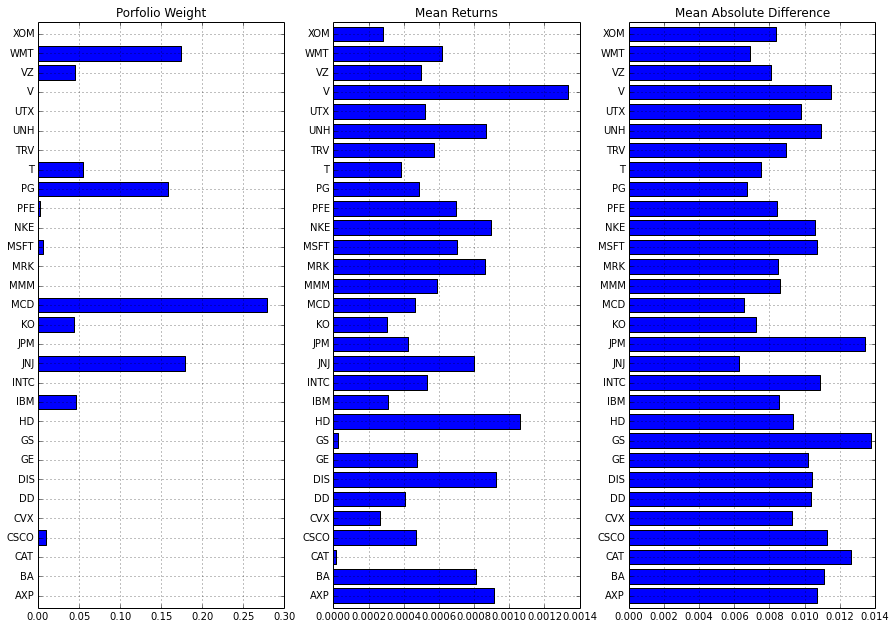

In [194]:
figure(figsize = (15,0.35*len(returns.columns)))

ws = pd.Series({s: w[s].varValue for s in portfolio},index=portfolio)

subplot(1,3,1)
ws.plot(kind='barh')
title('Porfolio Weight');

subplot(1,3,2)
returns.mean().plot(kind='barh')
title('Mean Returns');

subplot(1,3,3)
abs(returns-returns.mean()).mean().plot(kind='barh')
title('Mean Absolute Difference');

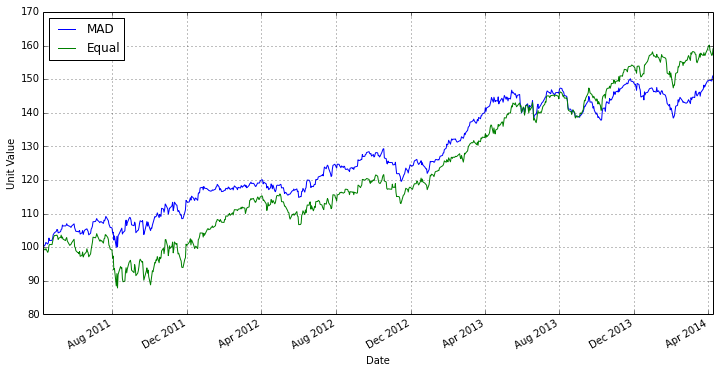

In [195]:
P_mad = pd.Series(0,index=adjclose.index)
for s in portfolio:
    P_mad += 100.0*ws[s]*adjclose[s]/adjclose[s][0]
    
figure(figsize=(12,6))
P_mad.plot()
P_equal.plot()
legend(['MAD','Equal'],loc='best')
ylabel('Unit Value')

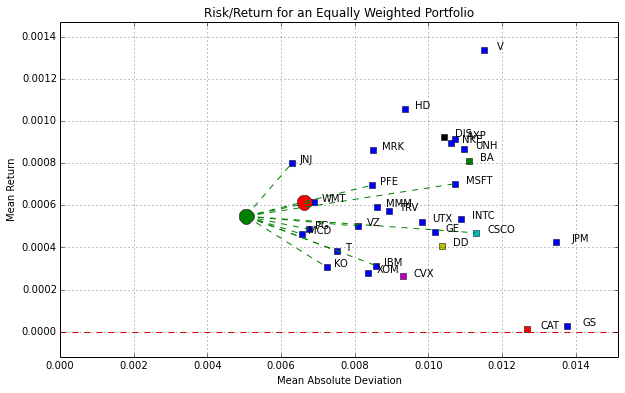

In [196]:
figure(figsize=(10,6))
for s in portfolio:
    plot(mad[s],rmean[s],'s')
    text(mad[s]*1.03,rmean[s],s)
    
axis([0, 1.1*max(mad), min([0,min(rmean)-.1*(max(rmean)-min(rmean))]), 1.1*max(rmean)])
ax = axis()
plot([ax[0],ax[1]],[0,0],'r--');

#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plot(M_equal,R_equal.mean(),'ro',ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

for s in portfolio:
    if ws[s] >= 0.0001:
        plot([M_mad,mad[s]],[R_mad.mean(),rmean[s]],'g--')

plot(M_mad,R_mad.mean(),'go',ms=15)

title('Risk/Return for an Equally Weighted Portfolio')
xlabel('Mean Absolute Deviation')
ylabel('Mean Return')

grid();

## Problem 1: Solve for Dominating MAD Portfolio

In [94]:
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)
lp += m    
lp += m == pulp.lpSum([(y[t] + z[t])/float(len(returns.index)) for t in tmap.values()])
lp += pulp.lpSum([w[s] for s in symbols]) == 1.0

for t in returns.index:
    lp += y[tsec[t]] - z[tsec[t]] == pulp.lpSum([w[s]*(returns[s][t]-rmean[s]) for s in symbols]) 
        
lp.solve()
m_min = m.varValue
m_min

NameError: name 'tmap' is not defined

In [95]:
# Solve for maximum return at minimum MAD

r = pulp.LpVariable('r',lowBound = 0)

lp = pulp.LpProblem('MAD Portfolio',pulp.LpMaximize)
lp += r
lp += r == pulp.lpSum([w[s]*rmean[s] for s in symbols])
lp += m_min == pulp.lpSum([(y[t] + z[t])/float(len(returns.index)) for t in tmap.values()])
lp += pulp.lpSum([w[s] for s in symbols]) == 1.0
for t in returns.index:
    lp += y[tsec[t]] - z[tsec[t]] == pulp.lpSum([w[s]*(returns[s][t]-rmean[s]) for s in symbols]) 
        
lp.solve()
r_min = r.varValue
w_min = pd.Series([pulp.value(w[s]) for s in symbols], index= symbols)

NameError: name 'symbols' is not defined